In [343]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
import random
import pickle
import networkx as nx

In [344]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [345]:
# NUMBER_NODES = 10
# NUMBER_NODES = 9
NUMBER_NODES = 7
# NUMBER_NODES = 5
DATASET_PATH = f'../../datasets/examples/opt_band_{NUMBER_NODES}_nodes_graph.csv'

In [346]:
def load_data():
    # not being used, but works as another approach to load the data
    def get_split_tensor_dataset(df, numberDigits):
        # df.iloc[row_start (0 default) : row_end (last default) , col_start (0 default) : col_end (last default)]
        X_df = df.iloc[ : , 0: numberDigits]
        Y_df = df.iloc[ : , numberDigits + 1 : ] # skip bandwidth value, and get the remaining labels
        X = X_df.to_numpy()
        Y = Y_df.to_numpy()
        return torch.from_numpy(X), torch.from_numpy(Y)

    # numberDigits = (NUMBER_NODES * NUMBER_NODES - NUMBER_NODES) // 2
    # if numberDigits == 45: # o de 10 nao ta otimizado AJEITAR
    #   numberDigits = 100
    featuresNumber = ((NUMBER_NODES * NUMBER_NODES - NUMBER_NODES) // 2 ) + 1 # + 1 to get opt band

    def get_tuple_tensor_dataset(row):
        X = row[0 : featuresNumber].astype('float32')
        # Y = row[numberDigits + 1 : ].astype('float32') # o de 10 nao ta otimizado AJEITAR
        Y = row[featuresNumber - 1: ].astype('float32') # - 1 to include opt band
        return torch.from_numpy(X), torch.from_numpy(Y)
        

    df = pd.read_csv(DATASET_PATH)
    # df = df.sample(frac=1).reset_index(drop=True) # shuffle
    train_dataset_df = df.sample(frac=0.8)
    df_remaining = df.drop(index=train_dataset_df.index)
    val_dataset_df = df_remaining.sample(frac=0.7)
    test_dataset_df = df_remaining.drop(index=val_dataset_df.index)

    train_dataset = list(map(get_tuple_tensor_dataset, train_dataset_df.to_numpy()))
    val_dataset = list(map(get_tuple_tensor_dataset, val_dataset_df.to_numpy()))
    test_dataset = list(map(get_tuple_tensor_dataset, test_dataset_df.to_numpy()))
    return train_dataset, val_dataset, test_dataset

    # X_train, Y_train = get_split_tensor_dataset(train_dataset_df, numberDigits)
    # X_val, Y_val = get_split_tensor_dataset(val_dataset_df, numberDigits)
    # X_test, Y_test = get_split_tensor_dataset(test_dataset_df, numberDigits)
    # return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [347]:
training_data, val_data, test_data = load_data()

# Save test_Data to use it in compareResults
with open('test_data.pickle', 'wb') as f:
    pickle.dump(test_data, f, pickle.HIGHEST_PROTOCOL)

train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)

In [348]:
for x, y in train_dataloader:
    print("Shape of X [Batches, Digits in each Batch]: ", x.shape)
    print("Grad = ", x.requires_grad)
    print("Shape of y [Batches, Optimal labels in each Batch]: ", y.shape)
    break

Shape of X [Batches, Digits in each Batch]:  torch.Size([16, 22])
Grad =  False
Shape of y [Batches, Optimal labels in each Batch]:  torch.Size([16, 8])


In [349]:
def get_bandwidth_nn_output(Graph, nodelist):
    Graph = np.array(Graph, dtype=np.int32)
    Graph = nx.Graph(Graph)
    L = nx.laplacian_matrix(Graph, nodelist=nodelist.cpu().detach().numpy())
    x, y = np.nonzero(L)
    return (x-y).max()

def getGraph(upperTriangleAdjMatrix):
    dense_adj = np.zeros((NUMBER_NODES, NUMBER_NODES))
    dense_adj = np.zeros((NUMBER_NODES, NUMBER_NODES))
    k = 0
    for i in range(NUMBER_NODES):
        for j in range(NUMBER_NODES):
            if i == j:
                continue
            elif i < j:
                dense_adj[i][j] = upperTriangleAdjMatrix[k]
                k += 1
            else:
                dense_adj[i][j] = dense_adj[j][i]
    return dense_adj

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(((NUMBER_NODES * NUMBER_NODES - NUMBER_NODES) // 2 ) + 1, 128)
        self.fc2 = nn.Linear(128, NUMBER_NODES)

    def forward(self, x):
        # print("FELIPEEEEEEEEEEEEE")
        # print(type(x))
        # print(x[0])
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# class CustomLoss(nn.Module):
    
#     def __init__(self):
#         super().__init__()
        
#     def forward(self, X, output, target):
#         # print("FELIPE")
#         # print(output[0].round())
#         # print(target[0])
#         labels = np.arange(NUMBER_NODES)
#         roundedOutput = output.round()

#         isValid = True
#         for label in labels:
#             if label not in roundedOutput:
#                 isValid = False
#                 break
#         if isValid:
#             loss = []
#             for i, input in enumerate(X):
#                 Graph = getGraph(X)
#                 output_band = get_bandwidth_nn_output(Graph, output[i])
#                 opt_band = target[i][-1]
#                 loss.append((output_band - opt_band)**2)
#             loss = np.array(loss)
#             return loss.mean()
#         else:
#             return (np.sum(labels) * output.shape[0]) - output.sum()**2

# if valid diff of loss, else MSE, opt_band both in training and target
def CustomLoss(X):
    def loss_fn(output, target):
        labels = np.arange(NUMBER_NODES)
        roundedOutput = output.round()

        isValid = True
        for label in labels:
            if label not in roundedOutput:
                isValid = False
                break
        if isValid:
            try:
                Graph = getGraph(X.cpu().detach().numpy())
                output_band = get_bandwidth_nn_output(Graph, roundedOutput)
                loss = (output_band - target[0])**2
                # print("CHEKCPOINT 2")
                # print(((output_band - target[0])**2).mean())
                # print(output_band)
                # print(target[0].dtype)
                # print(loss.dtype)
                loss.requires_grad_(True)
                return loss
            except Exception as e:
                print("Felipe 2 error")
                print(e)
                print(output_band)
                print(target[0])
                print(((output_band - target[0])**2).mean())
        else:
            try:
                # loss = np.sum(labels) - output.sum()
                # if loss < 0:
                #     loss *= -1
                # print("FELIPEEEEEEEEEEEEEE")
                # print(output.shape)
                # print(target[1:].shape)
                # return loss + ((output - target[ 1 : ])**2).mean()
                return ((output - target[ 1 : ])**2).mean() # another idea, calculate the euclidean distance
            except Exception as e:
                print("felipe error")
                print(e)
                print(output.shape)
                print(target.shape)
                print(output)
                print(target[1 : ])
                # print((output - target[ 1 : ]))
                # print(((output - target[ 1 : ])**2))
                # print(((output - target[ 1 : ])**2).mean())
    return loss_fn

In [350]:
# train v2 https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

def train(dataloader, model, optimizer, goal, epoch):
    model.train() # turn on possible layers/parts specific for training, like Dropouts for example
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        for input, target in zip(X, y):
            input, target = input.to(device), target.to(device)
            pred = model(input)
            loss_fn = CustomLoss(input)
            loss = loss_fn(pred, target)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # print statistics
            if train_loss == 0:
                print(f'Epoch {epoch + 1} Loss: {loss.item()}')

            train_loss += loss.item()

            # goal
            # if loss.item() <= goal:
            #     print('The goal of learning is reached')
            #     print(f'{epoch + 1} Loss: {loss.item()}')
            #     break
    return (train_loss / len(dataloader))

def validate(dataloader, model):
    model.eval() # turn off possible layers/parts specific for training, like Dropouts for example
    eval_loss = 0
    # with torch.no_grad(): # turn off gradients computation
    for x, y in dataloader:
        for input, target in zip(x, y):
            input, target = input.to(device), target.to(device)
            pred = model(input)
            loss_fn = CustomLoss(input)
            loss = loss_fn(pred, target)
            eval_loss += loss.item()
    return (eval_loss / len(dataloader))
    

def test(dataloader, model, epoch):
    # size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad(): # turn off gradients computation
        for X, y in dataloader:
            correct_batch = 0
            for input, target in zip(X, y):
                input, target = input.to(device), target.to(device)
                pred = model(input)
                loss_fn = CustomLoss(input)
                loss = loss_fn(pred, target)
                test_loss += loss.item()
                t = target[1 : ]
                p = pred.round()
                correct_batch += t.eq(p).sum().type(torch.float32)
                correct_batch /= len(input)
            correct += correct_batch / len(X)
    test_loss /= num_batches
    # print("CHECKPOINTTT")
    # print(correct)
    # print(size)
    # correct /= size
    if epoch % 10 == 0:
      print(f"Test loss:\nAccuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [351]:
epochs = 512

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model = NeuralNetwork().to(device)
print(model)

optimizer = optim.SGD(model.parameters(), lr=0.001)

list_train_loss = []
list_val_loss = []

goal = 0.5e-3

for epoch in range(epochs):
    # for each epoch, we got a loss training and a loss validating.
    train_epoch_loss = train(train_dataloader, model, optimizer, goal, epoch)
    list_train_loss.append(train_epoch_loss)
    val_epoch_loss = validate(val_dataloader, model)
    list_val_loss.append(val_epoch_loss)
    test(test_dataloader, model, epoch)

torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Using cuda device
NeuralNetwork(
  (fc1): Linear(in_features=22, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=7, bias=True)
)
Epoch 1 Loss: 14.089336395263672
Test loss:
Accuracy: 0.3%, Avg loss: 60.762498 

Epoch 2 Loss: 4.925979137420654
Epoch 3 Loss: 1.976629376411438
Epoch 4 Loss: 4.888278007507324
Epoch 5 Loss: 2.8782365322113037
Epoch 6 Loss: 4.101294994354248
Epoch 7 Loss: 3.4269464015960693
Epoch 8 Loss: 2.4958105087280273
Epoch 9 Loss: 3.1125261783599854
Epoch 10 Loss: 3.408386468887329
Epoch 11 Loss: 3.760416030883789
Test loss:
Accuracy: 1.8%, Avg loss: 54.119970 

Epoch 12 Loss: 4.43198299407959
Epoch 13 Loss: 4.485766410827637
Epoch 14 Loss: 4.337875843048096
Epoch 15 Loss: 6.542627811431885
Epoch 16 Loss: 0.9541230201721191
Epoch 17 Loss: 3.9784553050994873
Epoch 18 Loss: 1.3806204795837402


KeyboardInterrupt: 

512
512
Loss val array:
Loss val first:
55.7211069226265
Loss val last:
48.85180242136121
[72.93316637120157, 58.82752745556382, 57.70856379562954, 56.856252681534244, 56.1029487713328, 55.434963174586024, 54.81981589209359, 54.328091655137406, 53.83066314908693, 53.358843004928445, 52.954400970126095, 52.53310453554369, 52.258650685256384, 51.88292866607882, 51.57231722687775, 51.30858585744534, 51.09543459145528, 50.77878356373535, 50.60358421869998, 50.412500630572154, 50.23336820107586, 50.004809219882176, 49.93944522063687, 49.71736718348737, 49.59428153172979, 49.386880178496526, 49.396050255815936, 49.21640516564531, 49.14825141598593, 49.05401441960964, 49.0029599559757, 48.83895151626389, 48.824365429720785, 48.647222225396135, 48.65711052800125, 48.44346442087641, 48.519466192654846, 48.52720845195482, 48.40717690030359, 48.270415434859835, 48.25895477803248, 48.20030353907144, 48.01616636312233, 48.05743459035765, 47.98803086719423, 47.96343826741543, 47.91852275970972, 47.9

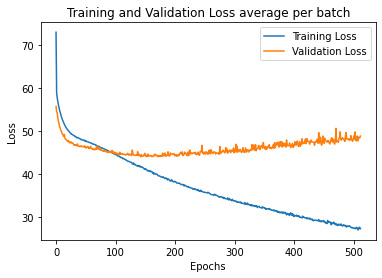

In [ ]:
print(len(list_train_loss))
print(len(list_val_loss))
print("Loss val array:")
# print(list_val_loss)
print("Loss val first:")
print(list_val_loss[0])
print("Loss val last:")
print(list_val_loss[-1])

print(list_train_loss)

plt.plot(list_train_loss, label='Training Loss')
plt.plot(list_val_loss, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss average per batch')
plt.show()

In [ ]:
print(test_data[0])
print(type(test_data[0]))

for x, y in test_dataloader:
  x, y = x.to(device), y.to(device)
  pred = model(x).round()
  print("=============")
  print(pred)
  print(y)
  np_true = y.cpu().detach().numpy()
  np_pred = pred.cpu().detach().numpy()

(tensor([0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 2.]), tensor([2., 1., 5., 6., 0., 3., 2., 4.]))
<class 'tuple'>
tensor([[ 4.,  4.,  2.,  3.,  2.,  4.,  2.],
        [ 2.,  2.,  4.,  5.,  3.,  3.,  3.],
        [ 3.,  4.,  1.,  0.,  4.,  4.,  4.],
        [ 2.,  3.,  4.,  2.,  2.,  4.,  3.],
        [ 2.,  2.,  5.,  3.,  3.,  3.,  1.],
        [ 2.,  3.,  6.,  4.,  4.,  1.,  2.],
        [ 1.,  2.,  4.,  6.,  3.,  2.,  2.],
        [ 1.,  3.,  3.,  6.,  2.,  3.,  2.],
        [ 1.,  2.,  6.,  6.,  3.,  0.,  3.],
        [ 3.,  2.,  4.,  1.,  6.,  2.,  2.],
        [ 3.,  1.,  3.,  5.,  4.,  2.,  3.],
        [ 3.,  5.,  1., -0.,  5.,  4.,  3.],
        [ 3.,  5.,  3., -0.,  2.,  5.,  3.],
        [ 1.,  3.,  6.,  4.,  1.,  3.,  2.],
        [ 1., -2.,  8.,  6.,  5.,  2.,  2.],
        [ 0.,  2.,  6.,  4.,  3.,  4.,  2.]], device='cuda:0',
       grad_fn=<RoundBackward>)
tensor([[2., 4., 1., 6., 5., 0., 3., 2.],
        [3., 2., 3., 5.

In [ ]:
def load_data_v1():
    # numberDigits = 100 # o de 10 nao ta otimizado AJEITAR
    featuresNumber = ((NUMBER_NODES * NUMBER_NODES - NUMBER_NODES) // 2) + 1

    def get_split_tensor_dataset(df, numberDigits):
        # df.iloc[row_start (0 default) : row_end (last default) , col_start (0 default) : col_end (last default)]
        # o de 10 nao ta otimizado AJEITAR
        X = df.iloc[ : , 0: numberDigits].values.astype('float32')
        Y = df.iloc[ : , numberDigits : ].values.astype('float32')
        return torch.from_numpy(X), torch.from_numpy(Y)

    df = pd.read_csv(DATASET_PATH)
    # df = df.sample(frac=1).reset_index(drop=True) # shuffle
    train_dataset_df = df.sample(frac=0.8)
    df_remaining = df.drop(index=train_dataset_df.index)
    val_dataset_df = df_remaining.sample(frac=0.7)
    test_dataset_df = df_remaining.drop(index=val_dataset_df.index)

    X_train, Y_train = get_split_tensor_dataset(train_dataset_df, featuresNumber)
    X_val, Y_val = get_split_tensor_dataset(val_dataset_df, featuresNumber)
    X_test, Y_test = get_split_tensor_dataset(test_dataset_df, featuresNumber)
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [ ]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = load_data_v1()
print(X_train.shape)
print(X_val.shape)
print(Y_val.shape)

torch.Size([835, 22])
torch.Size([146, 22])
torch.Size([146, 7])


In [ ]:
# train v1

model_v1 = NeuralNetwork()

loss_fn = CustomLoss()
optimizer = optim.SGD(model_v1.parameters(), lr=0.001)

epochs = 64
goal = 0.5e-3
batch_size = 16
train_size = len(X_train)
val_size = len(X_val)
steps = int(np.ceil(train_size / batch_size))
steps_val = int(np.ceil(val_size / batch_size))

list_train_loss_v1 = list()
list_val_loss_v1 = list()

print('\nTraining')
for epoch in range(epochs):
    start = 0
    end = batch_size
    loss_train = 0.0
    model.train()
    for batch in range(steps):
        x = X_train[start : end]
        y = Y_train[start : end]

        pred = model_v1(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_train += loss.item()

        start += batch_size
        end += batch_size

        # print statistics
        if not batch:
            print(f'Epoch {epoch + 1} Loss: {loss.item()}')
        # goal
        # if loss.item() <= goal:
        #     print('The goal of learning is reached')
        #     print(f'{epoch + 1} Loss: {loss.item()}')
        #     break
    start = 0
    end = batch_size
    loss_val = 0.0
    model.eval()
    for batch in range(steps_val):
        x = X_val[start : end]
        y = Y_val[start : end]
        pred = model_v1(x)
        loss = loss_fn(pred, y)
        loss_val += loss.item()
        start += batch_size
        end += batch_size

    list_train_loss_v1.append(loss_train / steps)
    list_val_loss_v1.append(loss_val / steps_val)
print('Finished Training')

TypeError: CustomLoss() missing 1 required positional argument: 'X'

[5.750450801741735, 5.438349005556947, 5.348948219379032, 5.3010043673802105, 5.271265330057018, 5.249444478304952, 5.23069425099313, 5.213820509450898, 5.198591982431246, 5.184857950801496, 5.172169638249453, 5.159923539839406, 5.148324539172904, 5.137135527514814, 5.126221050771022, 5.115574701967346, 5.105135576805208, 5.094994852024516, 5.085131092416645, 5.075609169118144, 5.06643894375959, 5.057660294651933, 5.049227731464314, 5.041178711293583, 5.033460578874016, 5.025993578972489, 5.018862238856613, 5.0119456724254645, 5.005309543374221, 4.998949734269227, 4.992761933857373, 4.9867936462159586, 4.981054847810195, 4.975526992976448, 4.970167773388281, 4.9649769646017, 4.959979189992454, 4.955129113575074, 4.95039987954681, 4.945766064491233, 4.9412844053293155, 4.936960039795686, 4.9327615792702355, 4.928727650618091, 4.924798106685448, 4.921011712382033, 4.917340921491137, 4.913737974382825, 4.910222807027062, 4.906787260522727, 4.9034459276353495, 4.900205437960333, 4.89698608

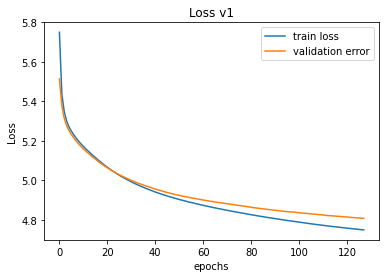

In [ ]:
# consolidate
print(list_train_loss_v1)
fig, ax = plt.subplots()
ax.plot(list_train_loss_v1, label='train loss')
ax.plot(list_val_loss_v1, label='validation error')
ax.set(xlabel='epochs', ylabel='Loss', title='Loss v1')

plt.legend()
#plt.savefig('loss.png')
plt.show()

In [ ]:
print(X_test[0])
print(type(X_test[0]))

for i in range(len(X_test)):
  pred = model_v1(X_test[i])
  print("====")
  print(pred.round())
  print(Y_test[i])

tensor([0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1.])
<class 'torch.Tensor'>
tensor([3., 4., 4., 5., 0., 4., 5., 5., 4.], grad_fn=<RoundBackward>)
tensor([1., 8., 0., 7., 3., 4., 6., 2., 5.])
[0.  0.  0.  0.  0.4 0.  0.  0.  0. ]
0.1111111111111111
0.044444444444444446
0.044444444444444446

tensor([4., 4., 3., 4., 3., 5., 4., 4., 4.], grad_fn=<RoundBackward>)
tensor([1., 7., 8., 0., 2., 6., 5., 3., 4.])
[0.         0.         0.         0.         0.28571429 0.
 0.         0.         0.        ]
0.1111111111111111
0.031746031746031744
0.031746031746031744

tensor([3., 4., 4., 3., 2., 7., 4., 4., 4.], grad_fn=<RoundBackward>)
tensor([1., 7., 0., 2., 8., 3., 4., 6., 5.])
[0.         0.         0.         0.         0.33333333 0.
 0.         0.         0.        ]
0.1111111111111111
0.03703703703703704
0.03703703703703704

tensor([3., 4., 4., 2., 2., 8., 5., 4., 3.], grad

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)
it = iter(train_dataloader)
it2 = iter(train_dataloader)
it3 = iter(train_dataloader)
i1 = next(it)[1]
i2 = next(it2)[1]
i3 = next(it3)[1]
print(i1)
print(i2)
print(i3)
print(np.array_equal(i1, i2))
print(np.array_equal(i1, i3))
print(np.array_equal(i2, i3))

tensor([[5., 6., 1., 8., 0., 7., 4., 3., 2.],
        [1., 5., 6., 8., 4., 7., 2., 0., 3.],
        [1., 4., 5., 8., 7., 0., 2., 6., 3.],
        [3., 1., 7., 8., 6., 4., 2., 5., 0.],
        [5., 3., 0., 8., 6., 4., 7., 1., 2.],
        [6., 5., 8., 1., 2., 7., 3., 0., 4.],
        [1., 4., 6., 0., 7., 8., 2., 5., 3.],
        [3., 0., 6., 4., 8., 7., 1., 5., 2.],
        [1., 3., 6., 4., 8., 7., 2., 0., 5.],
        [1., 4., 6., 7., 8., 3., 2., 0., 5.],
        [1., 4., 6., 2., 8., 7., 3., 5., 0.],
        [3., 0., 7., 5., 6., 8., 4., 2., 1.],
        [1., 6., 5., 8., 7., 0., 2., 3., 4.],
        [2., 1., 3., 5., 8., 7., 0., 6., 4.],
        [0., 3., 6., 5., 7., 8., 1., 2., 4.],
        [1., 7., 2., 8., 3., 6., 0., 4., 5.]])
tensor([[1., 5., 7., 4., 8., 2., 0., 6., 3.],
        [1., 4., 5., 7., 8., 0., 2., 3., 6.],
        [3., 8., 6., 0., 1., 5., 2., 4., 7.],
        [6., 2., 1., 5., 7., 8., 3., 0., 4.],
        [2., 5., 6., 1., 8., 0., 4., 7., 3.],
        [2., 5., 7., 6., 0., 1., 